In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#I am going to create an autoencoder using keras and model from keras.model because layers are functions .
import keras
#we will go through the use of these layers as we use them when they are needed later down.
from keras.layers import Convolution2D, Flatten, Dense, MaxPool2D, Activation, Dropout
from keras.layers import UpSampling2D, Reshape, ZeroPadding2D, Input
from keras.models import Model
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Data loading from MNIST dataset it is needed to be in the same directory as your script.

ds = pd.read_csv('train.csv')
ds.shape
#I am taking only 10000 examples to make the script run faster you can if you want take all the examples depending on 
#your computer's processing power.
data = ds.values[:10000]

In [3]:
#converting range of each pixel from 0 to 1.
X = data[:, 1:]/255.0
#Converting each y from just the class value(10000,1) to a vector representing 1 for the class it belongs to in(10000,10)
y = np_utils.to_categorical(data[:, 0])

print X.shape, y.shape

(10000, 784) (10000, 10)


In [4]:
#Creating training and testing data
#We don't need y as we are not predicting.
split = int(0.8 * X.shape[0])

X_train = X[:split].reshape((-1, 28, 28, 1))
X_test = X[split:].reshape((-1, 28, 28, 1))
print X_train.shape, X_test.shape

(8000, 28, 28, 1) (2000, 28, 28, 1)


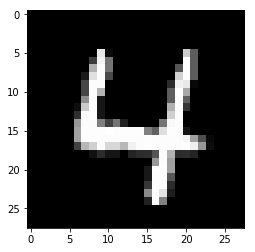

In [5]:
n_img = 42
#Just printing a random image in the mnist dataset
plt.imshow(X_train[n_img].reshape((28, 28)), cmap='gray')
plt.show()

In [53]:
#To properly see how convolution works or how kernel works please see CNN_MNIST . 

#We will first apply convolutional layer to take it down to 5,5,8 from 28,28,1 
inp = Input(shape=(28, 28, 1))  #This is the input layer

#First convolution layer with 32 kernels each of size 5,5 which gives us 24,24,32 i.e. 32 feature maps.

c1 = Convolution2D(32, (5, 5))
a1 = Activation('relu')

#Now we apply maxpool with 2,2 kernel to get 12,12,32 . 

m1 = MaxPool2D(pool_size=(2, 2))

#Second convolution layer with 8 kernels and 3,3 kernel size this gives us 10,10,8 image with 8 feature maps .

c2 = Convolution2D(8, (3, 3))
a2 = Activation('relu')

#Second maxpool with 2,2 kernel to get 5,5,8 .

m2 = MaxPool2D(pool_size=(2, 2))

#It is now flattened to 200 size vector .

f1 = Flatten()

#emb shape is the final shape of vector you need as the result of encoder i have set it to 32 it is mostly preferable to
#be a power of 2 we are using tanh as the activation function to wrap the input from -1 to 1 sigmoid is also good 
#as the output from it is 0 to 1

emb_shape = 32
e1 = Dense(emb_shape)
emb = Activation('tanh')

#We need sigmoid activation as if the input is -1 to 1in case we used tanh the we need it to be in 0 to 1 relu should be
#avoided as it will ignore values below 0 .

fc1 = Dense(200)
a3 = Activation('sigmoid')

#Recreating the matrix .

re1 = Reshape((5, 5, 8))

#We need to do upsampling it is the opposite of maxpool in this every value is put to the 4 cells opposite of maxpool.
#we get 10,10,8

up1 = UpSampling2D(size=(2, 2))

#Now we apply zeropadding (1,1) to get two zero rows and to get 2 zero columns so we end up with 12,12,8

zp1 = ZeroPadding2D(padding=(1, 1))

#We apply convolution to get 12,12,32 padding = 'true' makes sure that size of the output remains same as the size of 
#input thus instead of 10,10,32 we get 12,12,32 plus the borders instead of zeroes get some value filled in them .
#If we had applied convolution first and the padding then the borders would have remained zero .

dc1 = Convolution2D(32, (3, 3), padding='same', activation='relu')

#Upsampling is again done to get 24,24,32 .

up2 = UpSampling2D(size=(2, 2))

#We again repeat the deconvolution step to achieve 28,28,1 which was the original input .

zp2 = ZeroPadding2D(padding=(2, 2))
dc2 = Convolution2D(1, (5, 5), padding='same', activation='relu')

#Now we need to wrap them as fuctions of out_enc (output of encoder) and out_model (output of model).

out_enc = emb(e1(f1(m2(a2(c2(m1(a1(c1(inp)))))))))
out_model = dc2(zp2(up2(dc1(zp1(up1(re1(a3(fc1(out_enc)))))))))

#We finally complete the model building with this step .

model = Model(inputs=[inp], outputs=[out_model])
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

#This is the encoder model compling above model we dont need to complile encoder model.

encoder = Model(inputs=[inp], outputs=[out_enc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_13 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 8)         2312      
_________________________________________________________________
activation_14 (Activation)   (None, 10, 10, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 8)           0         
__________

In [7]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 8)         2312      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 8)           0         
__________

In [8]:
#Input to decoder .

dec_inp = Input(shape=(emb_shape,))

dec_out = dc2(zp2(up2(dc1(zp1(up1(re1(a3(fc1(dec_inp)))))))))
#Creating the decoder model no need to compile it .
decoder = Model(inputs=[dec_inp], outputs=[dec_out])
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               6600      
_________________________________________________________________
activation_4 (Activation)    (None, 200)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 8)           0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 10, 10, 8)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        2336      
__________

In [9]:
#We almost get 81 percent accuracy.Which is pretty good.
model.fit(X_train, X_train,
         epochs=10,
         shuffle=True,
        batch_size=100,
         validation_data=(X_test, X_test))

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 29s - loss: 0.0617 - acc: 0.8017 - val_loss: 0.0447 - val_acc: 0.8007
Epoch 2/10
8000/8000 [==============================] - 27s - loss: 0.0358 - acc: 0.8030 - val_loss: 0.0308 - val_acc: 0.8040
Epoch 3/10
8000/8000 [==============================] - 27s - loss: 0.0278 - acc: 0.8067 - val_loss: 0.0260 - val_acc: 0.8039
Epoch 4/10
8000/8000 [==============================] - 27s - loss: 0.0238 - acc: 0.8085 - val_loss: 0.0225 - val_acc: 0.8066
Epoch 5/10
8000/8000 [==============================] - 27s - loss: 0.0212 - acc: 0.8095 - val_loss: 0.0204 - val_acc: 0.8077
Epoch 6/10
8000/8000 [==============================] - 28s - loss: 0.0193 - acc: 0.8101 - val_loss: 0.0193 - val_acc: 0.8091
Epoch 7/10
8000/8000 [==============================] - 28s - loss: 0.0180 - acc: 0.8106 - val_loss: 0.0177 - val_acc: 0.8083
Epoch 8/10
8000/8000 [==============================] - 31s - loss: 0.

In [10]:
#Seeing how well does the encoder work for first 100 examples
enc_out = encoder.predict(X_train[:100])
print enc_out.shape

(100, 32)


In [12]:
#Putting the output of encoder in the decoder to recreate those images .
rec = decoder.predict(enc_out)
print rec.shape

(100, 28, 28, 1)


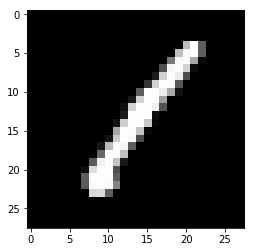

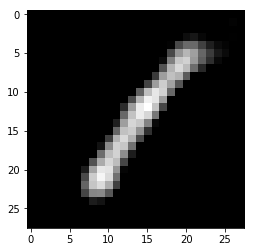

In [67]:
nx = 0

plt.figure(0)
plt.imshow(X_train[nx].reshape((28, 28)), cmap='gray')

plt.figure(1)
plt.imshow(rec[nx].reshape((28, 28)), cmap='gray')

plt.show()

In [54]:
#We will try to visualize feature maps at the end of second maxpool layer thus dd is made out of it by function wrapping
#we make a model en and using it we would visualize all the feature maps
dd = m2(a2(c2(m1(a1(c1(inp))))))
en = Model(inputs=[inp], outputs=[dd])
dd.shape

TensorShape([Dimension(None), Dimension(5), Dimension(5), Dimension(8)])

In [55]:
en.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_13 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 8)         2312      
_________________________________________________________________
activation_14 (Activation)   (None, 10, 10, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 8)           0         
Total para

In [56]:
#ee is the prediction of en on 100 examples of X_train .
ee = en.predict(X_train[:100])

In [57]:
print ee.shape

(100, 5, 5, 8)


In [58]:
#Now we will plot each of those feature maps . Each of these feature maps are a result of applying different kernels on
#the image . Kernels can be of different type see http://setosa.io/ev/image-kernels/ for understanding of kernels.

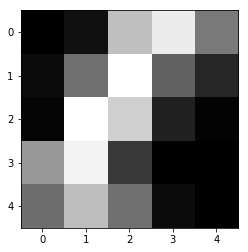

In [59]:
plt.imshow(ee[0,:,:,0],cmap='gray')

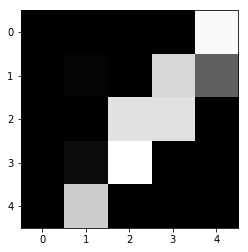

In [60]:
plt.imshow(ee[0,:,:,1],cmap='gray')

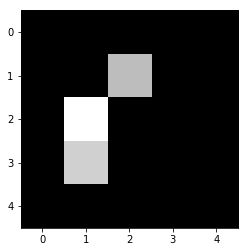

In [61]:
plt.imshow(ee[0,:,:,2],cmap='gray')

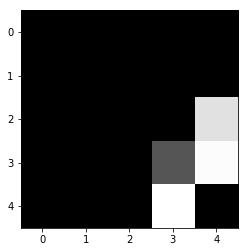

In [62]:
plt.imshow(ee[0,:,:,3],cmap='gray')

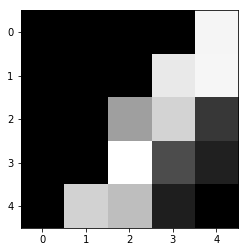

In [63]:
plt.imshow(ee[0,:,:,4],cmap='gray')

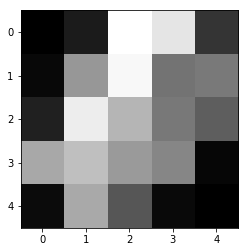

In [64]:
plt.imshow(ee[0,:,:,5],cmap='gray')

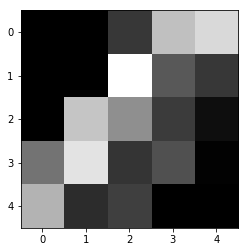

In [65]:
plt.imshow(ee[0,:,:,6],cmap='gray')

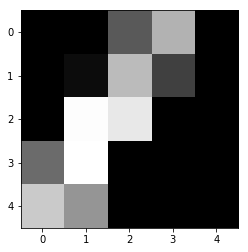

In [66]:
plt.imshow(ee[0,:,:,7],cmap='gray')